In [1]:
# Importations de packages
import numpy as np
import geopandas as gpd
import folium
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from shapely import Point
import seaborn as sns 

pd.options.display.max_columns = 999

In [2]:
from src.config import *
from src.utils import make_path, check_dir
from src.traitements import AppariementRunner
from src.traitements import get_communes_from_radius

### Utils

In [22]:
# stats ze

nums_cols = ['area',
       'number_mun', 'population_t0', 'density_pop_km2_t0', 'number_ware_t0',
       'number_ware_per_popM_t0', 'number_ware_per_1000km2_t0',
       'avg_size_ware_t0', 'gravity_t0', 'population_t1', 'density_pop_km2_t1',
       'number_ware_t1', 'number_ware_per_popM_t1',
       'number_ware_per_1000km2_t1', 'avg_size_ware_t1', 'gravity_t1',
       'pop_change', 'gravity_change', 'number_ware_change',
       'perc_ware_change', 'number_ware_per_popM_change', 'log_sprawl_measure'] 

def load_measure(roi_name, period=(2008, 2023)): 
    period_str = '_'.join(list(map(str, period)))
    out_dir = check_dir(project_path, "reports", roi_name)
    fpath = [make_path(f, out_dir) for f in os.listdir(out_dir) if period_str in f][0] 
    gdf = gpd.read_file(fpath)
    for c in nums_cols: 
        gdf[c] = gdf[c].astype(float)

    return gdf

In [23]:
def make_concat_ds_year(wh_t0, wh_t1, wh_t2, columns=None): 
    
    columns = columns if columns is not None else list(wh_t0.columns)

    df = pd.concat(
    [
        wh_t0[columns].rename({_:f"{_}_t0" for _ in columns}, axis=1), 
        wh_t1[columns].rename({_:f"{_}_t1" for _ in columns}, axis=1), 
        wh_t2[columns].rename({_:f"{_}_t2" for _ in columns}, axis=1)
    ], axis=1)

    return df

## LYON

### Evolution of wh Dist to centroid

In [24]:
roi_name = "lyon"

year_t0 = "2008"
year_t1 = "2013"
year_t2 = "2023"

s_buffer = 25

out_dir = check_dir(project_path, "reports", roi_name)
wh_app_path = make_path("Appariement", processed_data_path, roi_name, "{}") #roi_name, year, buffer_size

_fname = "Entrepots_{}_{}_{}km_app.gpkg" #roi_name, year, buffer_size
wh_app_path_t0 = make_path(_fname.format(roi_name.upper(), year_t0, s_buffer), wh_app_path.format(year_t0))
wh_app_path_t1 = make_path(_fname.format(roi_name.upper(), year_t1, s_buffer), wh_app_path.format(year_t1))
wh_app_path_t2 = make_path(_fname.format(roi_name.upper(), year_t2, s_buffer), wh_app_path.format(year_t2))

wh_t0 = gpd.read_file(wh_app_path_t0)
wh_t1 = gpd.read_file(wh_app_path_t1)
wh_t2 = gpd.read_file(wh_app_path_t2)

/tmp/ipykernel_29972/998646898.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wh_t0[col], ax=axes[0], label=year_t0, hist=False)
/tmp/ipykernel_29972/998646898.py:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wh_t1[col], ax=axes[0], label=year_t1,  hist=False)
/tmp/ip

median : t0 : 2008 : 6.753907996874046
median : t1 :2013 : 7.892539531912643
median : t1 :2023 : 10.544946026789257
mean : t0 : 2008 : 9.406872341284663
mean : t1 :2013 : 9.954356298397537
mean : t2 :2023 : 11.748735448756415


Text(0.5, 0.98, 'Evolution des distances des entrepôts au barycentre logistique')

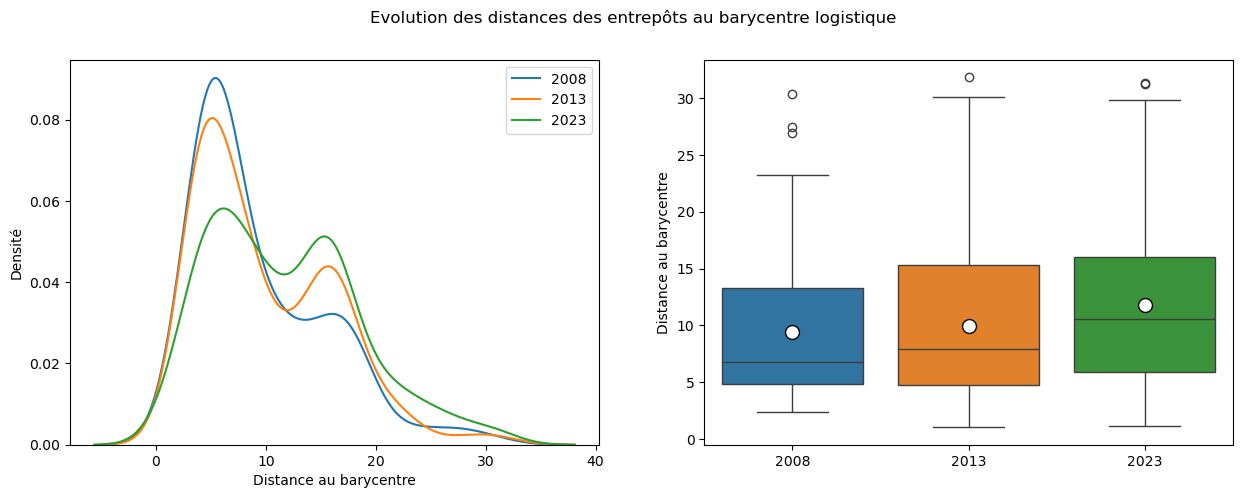

In [25]:
def get_dist_centroid(wh_df): 
    wh_centroid = np.mean(wh_df.centroid.x), np.mean(wh_df.centroid.y)
    return wh_df.distance(Point(wh_centroid)) / 1000

wh_t0["dist_centroid"] = get_dist_centroid(wh_t0)
wh_t1["dist_centroid"] = get_dist_centroid(wh_t1)
wh_t2["dist_centroid"] = get_dist_centroid(wh_t2)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

col = "dist_centroid"
median_t0 = np.median(wh_t0[col])
median_t1 = np.median(wh_t1[col])
median_t2 = np.median(wh_t2[col])

print(f"median : t0 : {year_t0} : {median_t0}")
print(f"median : t1 :{year_t1} : {median_t1}")
print(f"median : t1 :{year_t2} : {median_t2}")

print(f"mean : t0 : {year_t0} : {np.mean(wh_t0[col])}")
print(f"mean : t1 :{year_t1} : {np.mean(wh_t1[col])}")
print(f"mean : t2 :{year_t2} : {np.mean(wh_t2[col])}")

sns.distplot(wh_t0[col], ax=axes[0], label=year_t0, hist=False)
sns.distplot(wh_t1[col], ax=axes[0], label=year_t1,  hist=False)
sns.distplot(wh_t2[col], ax=axes[0], label=year_t2,  hist=False)

axes[0].set_xlabel("Distance au barycentre")
axes[0].set_ylabel("Densité")
axes[0].legend()


df_dist = pd.concat(
    [
        wh_t0["dist_centroid"].rename(f"{year_t0}"), 
        wh_t1["dist_centroid"].rename(f"{year_t1}"), 
        wh_t2["dist_centroid"].rename(f"{year_t2}")
    ], axis=1)


sns.boxplot(df_dist, 
            ax=axes[1],
            showmeans=True, 
            meanprops={
                "marker":"o",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"10"
            })

axes[1].set_ylabel("Distance au barycentre")

fig.suptitle('Evolution des distances des entrepôts au barycentre logistique', fontsize=12)

/tmp/ipykernel_29972/966212190.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([year_t0, year_t1, year_t2])


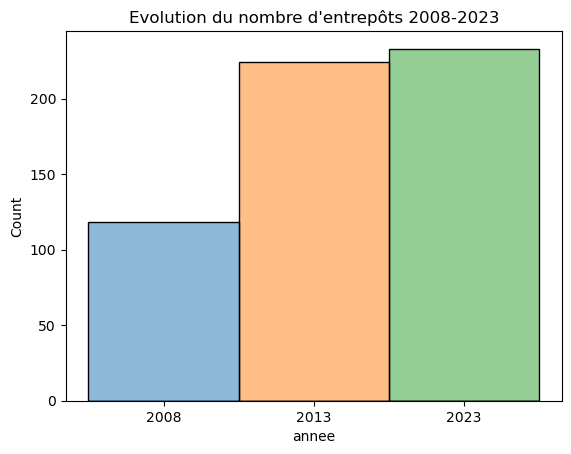

In [26]:
df_hist = make_concat_ds_year(wh_t0, wh_t1, wh_t2, columns=["ID"])
cnt = df_hist[["ID_t0","ID_t1", "ID_t2"]].melt(var_name="annee").dropna()
sns.histplot(x=cnt.annee, hue=cnt.annee, legend=False)
#plt.xticks_(plt.xticks(), labels=[year_t0, year_t1, year_t2])
ax = plt.gca()
ax.set_xticklabels([year_t0, year_t1, year_t2])
plt.title("Evolution du nombre d'entrepôts 2008-2023")
print()

In [27]:
cnt.annee.value_counts()

annee
ID_t2    233
ID_t1    224
ID_t0    118
Name: count, dtype: int64

2024-03-13 13:55:29,952 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-13 13:55:29,955 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(0.0, 0.18)

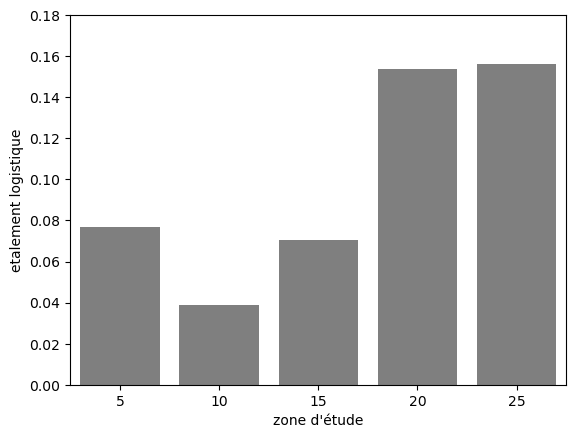

In [94]:
period = (2008, 2023)
df = load_measure(roi_name, period=period)

plot_df = df[["radius",  "log_sprawl_measure"]]
sns.barplot(plot_df, x="radius", y="log_sprawl_measure", color="tab:grey")
plt.xlabel("zone d'étude")
plt.ylabel("etalement logistique")
plt.ylim([0, 0.18])

## Bordeaux

In [10]:
roi_name = "bordeaux"

year_t0 = "2008"
year_t1 = "2013"
year_t2 = "2023"

s_buffer = 25

out_dir = check_dir(project_path, "reports", roi_name)
wh_app_path = make_path("Appariement", processed_data_path, roi_name, "{}") #roi_name, year, buffer_size


_fname = "Entrepots_{}_{}_{}km_app.gpkg" #roi_name, year, buffer_size
wh_app_path_t0 = make_path(_fname.format(roi_name.upper(), year_t0, s_buffer), wh_app_path.format(year_t0))
wh_app_path_t1 = make_path(_fname.format(roi_name.upper(), year_t1, s_buffer), wh_app_path.format(year_t1))
wh_app_path_t2 = make_path(_fname.format(roi_name.upper(), year_t2, s_buffer), wh_app_path.format(year_t2))

wh_t0 = gpd.read_file(wh_app_path_t0)
wh_t1 = gpd.read_file(wh_app_path_t1)
wh_t2 = gpd.read_file(wh_app_path_t2)

In [11]:
wh_centroid_t0 = np.mean(wh_t0.centroid.x), np.mean(wh_t0.centroid.y)
wh_centroid_t1 = np.mean(wh_t1.centroid.x), np.mean(wh_t1.centroid.y)
wh_centroid_t2 = np.mean(wh_t0.centroid.x), np.mean(wh_t2.centroid.y)

centroid_bdx_5km = gpd.GeoDataFrame(geometry=[Point(wh_centroid_t0), Point(wh_centroid_t1), Point(wh_centroid_t2)], crs=CRS) 
centroid_bdx_5km.to_file("centroid_bdx_5km.gpkg")

In [12]:
wh_centroid_t2

(415208.05452665035, 6424563.744101085)

/tmp/ipykernel_29972/2681047585.py:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wh_t0[col], ax=axes[0], label=year_t0, hist=False)
/tmp/ipykernel_29972/2681047585.py:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wh_t1[col], ax=axes[0], label=year_t1,  hist=False)
/tmp/

median : t0 : 2008 : 6.111803954649487
median : t1 :2013 : 6.685112878589824
median : t1 :2023 : 7.1505584327142575
mean : t0 : 2008 : 7.925846836876186
mean : t1 :2013 : 8.077962655181251
mean : t2 :2023 : 8.85127236383843
number wh : t0 : 2008 : 32
number wh : t1 :2013 : 99
number wh : t2 :2023 : 97


Text(0.5, 0.98, 'Evolution des distances des entrepôts au barycentre logistique')

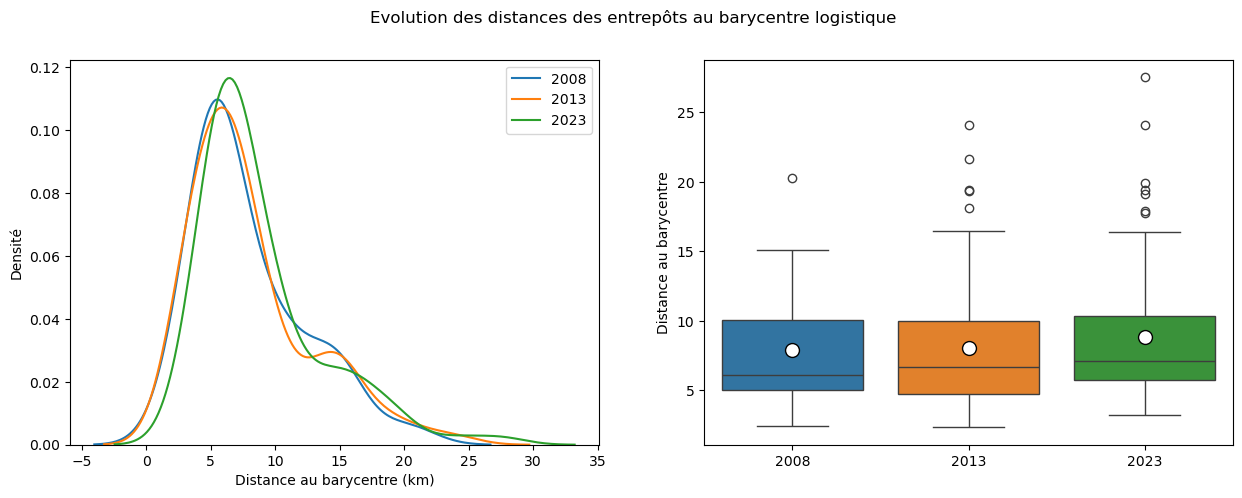

In [17]:
def get_dist_centroid(wh_df): 
    wh_centroid = np.mean(wh_df.centroid.x), np.mean(wh_df.centroid.y)
    return wh_df.distance(Point(wh_centroid)) / 1000

wh_t0["dist_centroid"] = get_dist_centroid(wh_t0)
wh_t1["dist_centroid"] = get_dist_centroid(wh_t1)
wh_t2["dist_centroid"] = get_dist_centroid(wh_t2)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

col = "dist_centroid"
median_t0 = np.median(wh_t0[col])
median_t1 = np.median(wh_t1[col])
median_t2 = np.median(wh_t2[col])

print(f"median : t0 : {year_t0} : {median_t0}")
print(f"median : t1 :{year_t1} : {median_t1}")
print(f"median : t1 :{year_t2} : {median_t2}")

print(f"mean : t0 : {year_t0} : {np.mean(wh_t0[col])}")
print(f"mean : t1 :{year_t1} : {np.mean(wh_t1[col])}")
print(f"mean : t2 :{year_t2} : {np.mean(wh_t2[col])}")

print(f"number wh : t0 : {year_t0} : {len(wh_t0[col])}")
print(f"number wh : t1 :{year_t1} : {len(wh_t1[col])}")
print(f"number wh : t2 :{year_t2} : {len(wh_t2[col])}")


sns.distplot(wh_t0[col], ax=axes[0], label=year_t0, hist=False)
sns.distplot(wh_t1[col], ax=axes[0], label=year_t1,  hist=False)
sns.distplot(wh_t2[col], ax=axes[0], label=year_t2,  hist=False)

axes[0].set_xlabel("Distance au barycentre (km)")
axes[0].set_ylabel("Densité")
axes[0].legend()


df_dist = pd.concat(
    [
        wh_t0["dist_centroid"].rename(f"{year_t0}"), 
        wh_t1["dist_centroid"].rename(f"{year_t1}"), 
        wh_t2["dist_centroid"].rename(f"{year_t2}")
    ], axis=1)


sns.boxplot(df_dist, 
            ax=axes[1], 
            showmeans=True, 
            meanprops={
                "marker":"o",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"10"
            })
axes[1].set_ylabel("Distance au barycentre")

fig.suptitle('Evolution des distances des entrepôts au barycentre logistique', fontsize=12)

In [23]:
0.75*32

24.0

/tmp/ipykernel_502247/769470566.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([year_t0, year_t1, year_t2])


Text(0.5, 1.0, "Evolution du nombre d'entrepôts 2008-2023")

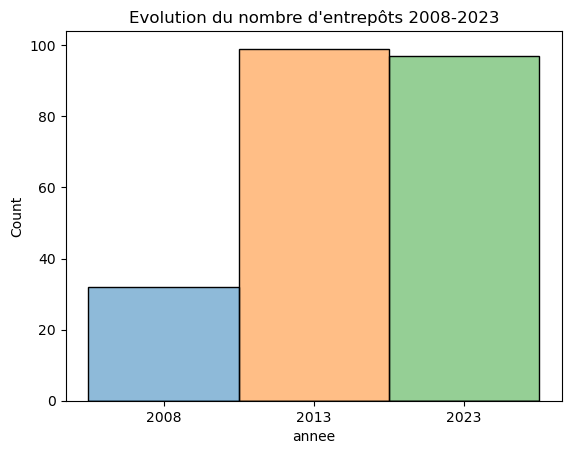

In [13]:
df_hist = make_concat_ds_year(wh_t0, wh_t1, wh_t2, columns=["ID"])

cnt = df_hist[["ID_t0","ID_t1", "ID_t2"]].melt(var_name="annee").dropna()
sns.histplot(x=cnt.annee, hue=cnt.annee, legend=False)
#plt.xticks_(plt.xticks(), labels=[year_t0, year_t1, year_t2])
ax = plt.gca()
ax.set_xticklabels([year_t0, year_t1, year_t2])
plt.title("Evolution du nombre d'entrepôts 2008-2023")

2024-03-14 14:39:40,158 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-14 14:39:40,162 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


(0.0, 0.18)

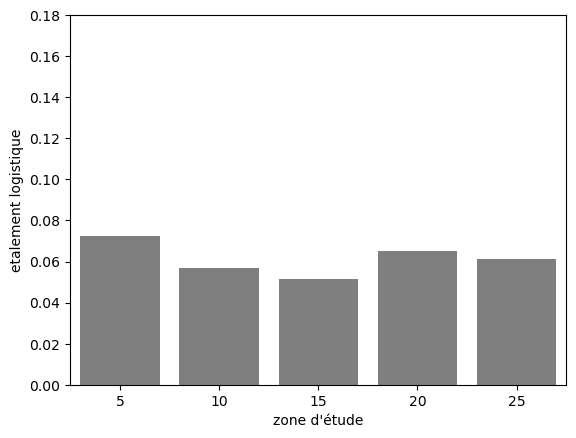

In [17]:
period = (2008, 2023)
df = load_measure(roi_name, period=period)

plot_df = df[["radius",  "log_sprawl_measure"]]
sns.barplot(plot_df, x="radius", y="log_sprawl_measure", color="tab:grey")
plt.xlabel("zone d'étude")
plt.ylabel("etalement logistique")
plt.ylim([0, 0.18])

## Database

In [106]:
db = pd.read_csv(make_path("Database_study.csv", data_path))

In [107]:
db = db[:74]

In [113]:
col_log_sprawl = 'Logistic sprawl (km/year)'

In [134]:
db[col_log_sprawl].str.replace(",", ".")

0      0.43
1      0.06
2      0.20
3      0.09
4      0.13
      ...  
69     0.05
70     0.71
71     0.14
72     0.40
73    -1.09
Name: Logistic sprawl (km/year), Length: 74, dtype: object

In [135]:
db[col_log_sprawl] = db[col_log_sprawl].str.replace(",", ".").astype(float).dropna()

In [114]:
db.columns

Index(['#', 'Name of studied metro area', 'Size of studied metro area (km2)',
       'Number of municipalities', 'Type of metropolitan area',
       'Type of land use control ', 'Gateway', 'Megaregion',
       'Name of Megaregion', 'Type of city', 'Focused Study', 'Interviews',
       'Name of warehouse data source',
       'Time period studied for logistics sprawl analysis',
       'Number of years analysed', 'First year of study (T=0)',
       'T=0 Population (millions)', 'T=0 Population density (inhabitants/km2)',
       'T=0  Number of warehouses',
       'T=0 Number of warehouses per million people',
       'T=0 Number of warehouses per 1000 km2 ',
       'T=0 Average size of warehouses (m2)', 'Last year of study (T=N)',
       'T=N Population (millions)', 'T=N Population density (inhabitants/km2)',
       'T=N  Number of warehouses',
       'T=N Number of warehouses per million people',
       'T=N Number of warehouses per 1000 km2 ',
       'T=N Average size of warehouses (m2)',

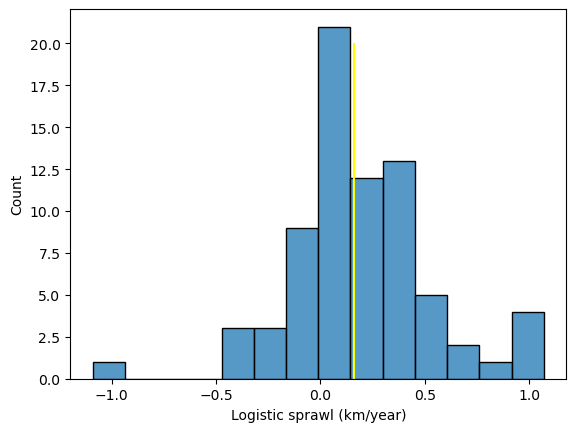

In [141]:
sns.histplot(db[col_log_sprawl])
plt.vlines(x=0.16, ymin=0, ymax=20, color="yellow")

In [131]:
(db[col_log_sprawl].values)

array(['0,43', '0,06', '0,20', '0,09', '0,13', '0,08', '0,35', '0,17',
       '0,59', '1,07', '0,55', '0,30', '0,19', '0,11', '0,89', '0,03',
       '-0,33', '0,51', '0,33', '0,16', '0,00', '-0,12', '0,31', '0,00',
       '0,18', '0,95', '0,12', '0,08', '0,42', '0,00', '-0,17', '0,33',
       '0,31', '0,12', '0,26', '0,20', '-0,08', '0,59', '0,50', '0,25',
       '0,00', '-0,09', '-0,29', '0,20', '-0,07', '0,12', '-0,03',
       '-0,04', '0,45', '0,05', '-0,04', '0,00', '0,72', '0,31', '0,03',
       '0,44', '-0,21', '0,98', '1,04', '0,21', '0,01', '-0,37', '-0,03',
       '0,24', '0,00', '0,20', '0,39', '-0,32', '-0,06', '0,05', '0,71',
       '0,14', '0,40', '-1,09'], dtype=object)

<Axes: ylabel='Logistic sprawl (km/year)'>

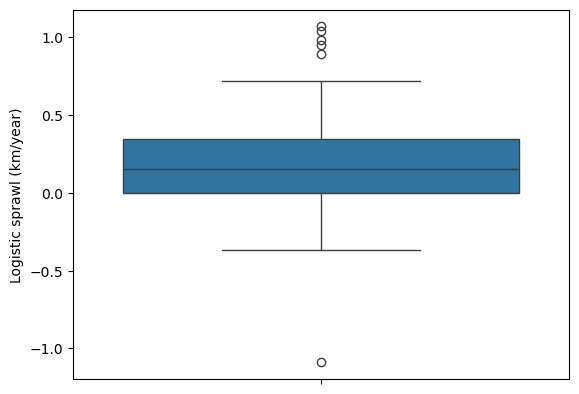

In [138]:
sns.boxplot(db[col_log_sprawl])

## Annexes

In [221]:
df

,radius,metro,mega_region,country,continent,data_sources,time_period_start,time_period_end,years_data,surfaces_area_available,urban_centrality,gateway,area,number_mun,population_t0,density_pop_km2_t0,number_ware_t0,number_ware_per_popM_t0,number_ware_per_1000km2_t0,avg_size_ware_t0,gravity_t0,population_t1,density_pop_km2_t1,number_ware_t1,number_ware_per_popM_t1,number_ware_per_1000km2_t1,avg_size_ware_t1,gravity_t1,pop_change,gravity_change,number_ware_change,perc_ware_change,number_ware_per_popM_change,log_sprawl_measure,geometry
0,5,lyon,,France,Europe,"BDTOPO_IGN,SIREN",2008,2023,15,True,,,166.0,14,0.82,4929.9,33,40.0,0.0001988668036324916,5294.38,3.47,1.16,6975.17,29,25.0,0.00017473411150777576,3598.66,4.62,0.33999999999999997,1.15,-4,-12.121212121212121,-15.0,0.07666666666666666,None
1,10,lyon,,France,Europe,"BDTOPO_IGN,SIREN",2008,2023,15,True,,,507.6,50,1.23,2437.05,79,64.0,0.00015648117338853756,5298.68,6.03,1.7,3352.14,100,59.0,0.00019700745529619513,4396.42,6.61,0.47,0.5800000000000001,21,26.582278481012654,-5.0,0.03866666666666667,None
2,15,lyon,,France,Europe,"BDTOPO_IGN,SIREN",2008,2023,15,True,,,939.4,94,1.46,1558.64,95,65.0,0.00010112269154440266,5598.12,7.05,2.11,2245.59,144,68.0,0.0001532837547820094,5439.66,8.11,0.6499999999999999,1.0599999999999996,49,51.578947368421055,3.0,0.07066666666666664,None
3,20,lyon,,France,Europe,"BDTOPO_IGN,SIREN",2008,2023,15,True,,,1664.6,148,1.69,1036.56,101,60.0,6.200333132561778e-05,5701.53,7.52,2.48,1491.0,173,70.0,0.00010392868625654931,6490.78,9.83,0.79,2.3100000000000005,72,71.28712871287128,10.0,0.15400000000000003,None
4,25,lyon,,France,Europe,"BDTOPO_IGN,SIREN",2008,2023,15,True,,,2386.7,216,1.91,802.14,118,62.0,4.9440055431413705e-05,6376.98,9.41,2.82,1181.97,233,83.0,9.762407825448895e-05,8925.48,11.75,0.9099999999999999,2.34,115,97.45762711864407,21.0,0.156,None


In [239]:
columns = ["radius"] + ["pop_change", "gravity_change", "number_ware_change", "number_ware_per_popM_change", "log_sprawl_measure"]
df[columns].dtypes

radius                         object
pop_change                     object
gravity_change                 object
number_ware_change             object
number_ware_per_popM_change    object
log_sprawl_measure             object
dtype: object

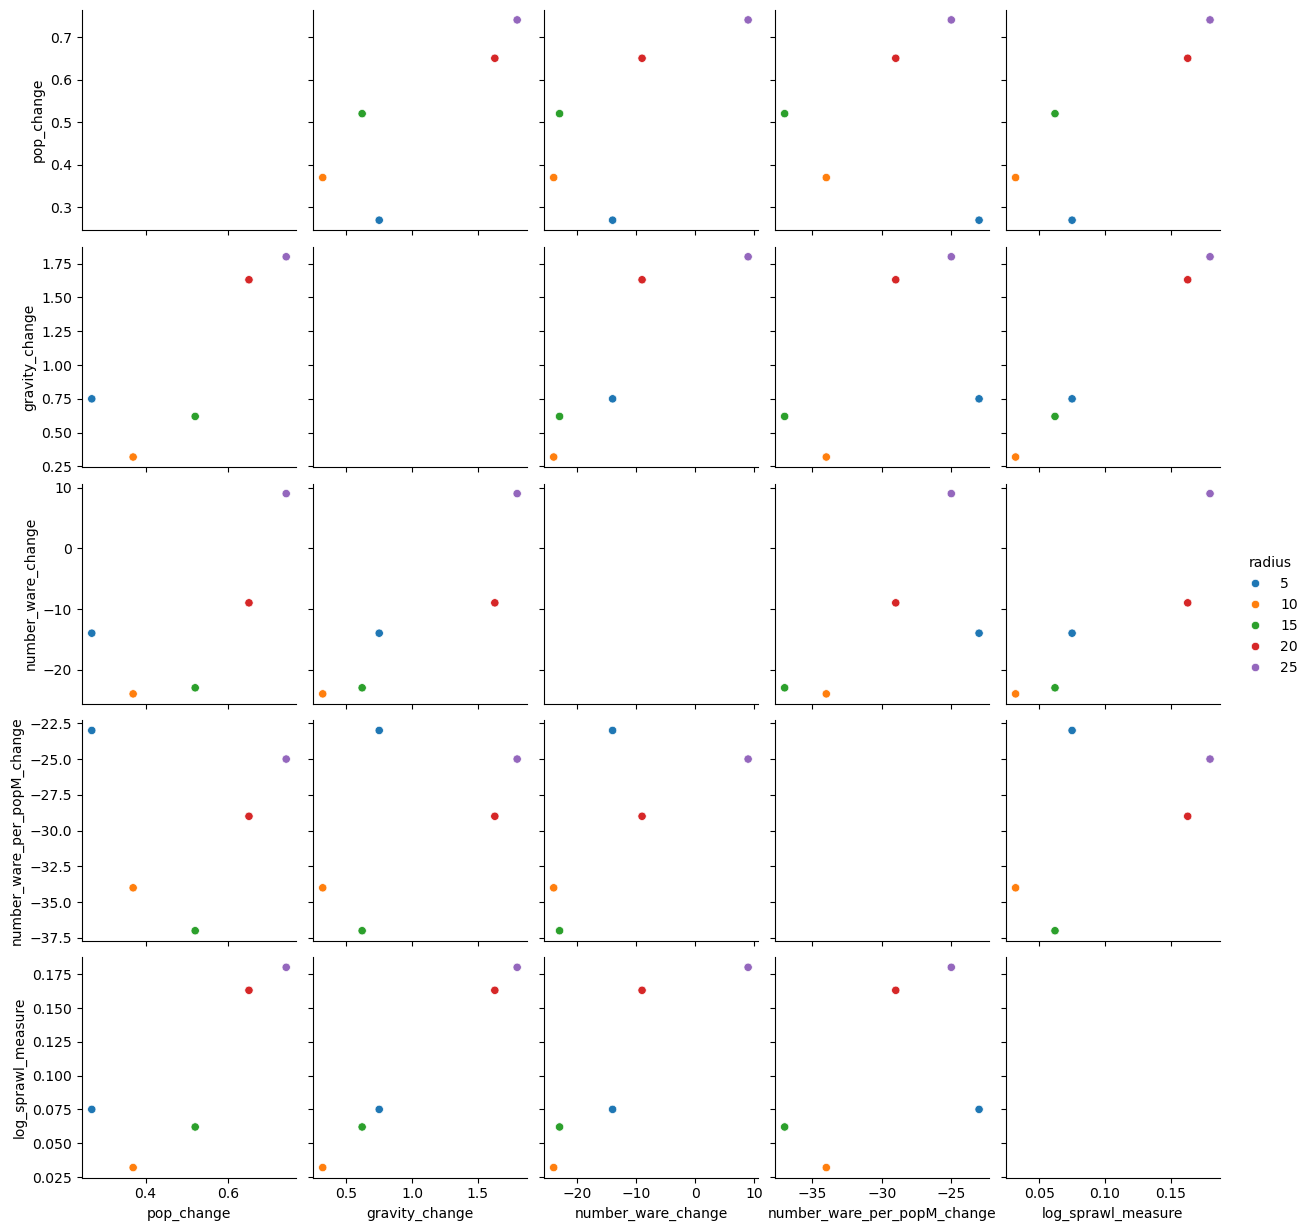

In [246]:
columns = ["radius"] + ["pop_change", "gravity_change", "number_ware_change", "number_ware_per_popM_change", "log_sprawl_measure"]
sns.pairplot(df[columns], hue="radius")

2024-03-11 15:24:06,549 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-11 15:24:06,551 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-11 15:24:06,553 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-11 15:24:06,553 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<BarContainer object of 5 artists>

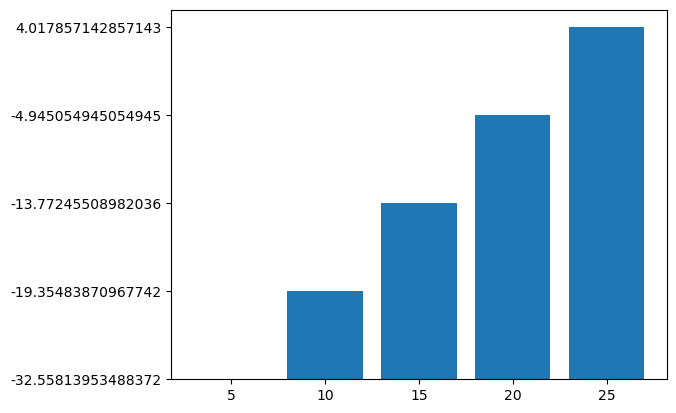

In [233]:
plt.bar(df.radius, df.perc_ware_change)

In [234]:
df.perc_ware_change

0    -32.55813953488372
1    -19.35483870967742
2    -13.77245508982036
3    -4.945054945054945
4     4.017857142857143
Name: perc_ware_change, dtype: object